In [22]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import FunctionTransformer,LabelEncoder
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Input, Flatten, Dense
from keras.optimizers import Adam

In [23]:
dir = "/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer"

In [24]:
# os.listdir(dir)
df = pd.read_csv("/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv")
df.dropna(axis = 0, inplace = True)
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [34]:
df.targets.unique()

array([3, 1, 0, 2])

In [25]:
label_encoder = LabelEncoder()
df['targets'] = label_encoder.fit_transform(df.dx_type)
df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,targets
3012,HAM_0002943,ISIC_0026054,nv,follow_up,50.0,male,lower extremity,2
3985,HAM_0001543,ISIC_0029639,nv,follow_up,60.0,female,foot,2
4882,HAM_0003160,ISIC_0029587,nv,follow_up,75.0,female,back,2
1030,HAM_0003049,ISIC_0027041,bkl,consensus,75.0,male,hand,1
1952,HAM_0005467,ISIC_0024640,mel,histo,55.0,female,back,3


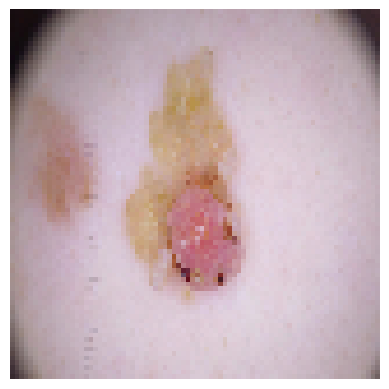

In [26]:
# Define the image path
image_path = os.path.join(dir, df.image_id[10] + '.jpg')

# Load the image
img = mpimg.imread(image_path)
img_size =80
# Reshape the image
img_resized = cv2.resize(img ,(img_size, img_size))  # Reshape to 50x50 while preserving the number of color channels

# Display the resized image
plt.imshow(img_resized)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()



In [27]:
img_size =80
X_train, X_test, y_train, y_test = train_test_split(df.image_id, df.targets, test_size=0.25, random_state=42)

In [28]:
X_train_images = []
for image_id in X_train:
    image_path = os.path.join(dir, image_id + '.jpg')
    image = mpimg.imread(image_path)
    image = cv2.resize(image ,(img_size, img_size))  # Resize to your desired input size
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    X_train_images.append(image)
X_train_images = np.array(X_train_images)

In [29]:
print("shape of training dataset :" ,len(X_train_images))

shape of training dataset : 7468


In [30]:
X_test_images = []
for image_id in X_test:
    image_path = os.path.join(dir, image_id + '.jpg')
    image = mpimg.imread(image_path)
    image = cv2.resize(image ,(img_size, img_size))  # Resize to your desired input size
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    X_test_images.append(image)
X_test_images = np.array(X_test_images)

In [31]:
print("shape of training dataset :" ,len(X_test_images) , " " , len(y_test))

shape of training dataset : 2490   2490


In [43]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train_encoded, test_size=0.2, random_state=42)

# Load the ResNet-50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add your custom classification layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
num_classes = 4
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
# model.summary()

# Train the model
batch_size = 32
epochs = 10
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 86, 86, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 40, 40, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 40, 40, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv4_block4_2_conv (Conv2D)   (None, 5, 5, 256)    590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 5, 5, 256)   1024        ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 5, 5, 256)   0           ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 5, 5, 1024)   263168      ['conv4_block4_2_relu[0][0]']    
                                                                                                  
 conv4_blo

In [49]:
predictions = model.predict(X_test_images)

78/78 [==============================] - 1s 19ms/step


In [50]:
# Get the predicted class labels for each test image
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted class labels for the first few test images
print("Predicted Class Labels for the First Few Test Images:")
print(predicted_labels)


Predicted Class Labels for the First Few Test Images:
[2 2 2 ... 1 2 3]


In [51]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.91


In [52]:
import pickle
from keras.models import save_model

# Save the model to a file
model.save('my_model.h5')


In [53]:
from keras.models import load_model

# Load the model from the file
loaded_model = load_model('/kaggle/working/my_model.h5')
